In [ ]:
%%capture

%cd ..

### Get MMLU and MuTual (no speaker tags) contexts

In [ ]:
from pathlib import Path
from typing import List, Optional, Union

from datasets import DatasetDict, load_dataset

from baseline.conf import DATA_DIR
from baseline.multi_choice.utils_multiple_choice import MuTualProcessor, InputExample


def get_mmlu_contexts(
    mmlu: Optional[DatasetDict] = None,
    subset: str = "all",
    split: str = "auxiliary_train",
) -> List[str]:
    """"""
    valid_splits = ["auxiliary_train", "test", "validation", "dev"]
    assert (
        split in valid_splits
    ), f"Unknown MMLU split {split!r}, available: {valid_splits}"
    if mmlu is None:
        mmlu = load_dataset("cais/mmlu", name=subset)
    return [dp["question"] for dp in mmlu[split]]


def get_mutual_contexts(
    data_dir: Union[Path, str] = DATA_DIR,
    subset: str = "mutual_plus",
    processor: Optional[MuTualProcessor] = None,
    split: str = "train",
    remove_context_speakers: bool = True,
) -> List[str]:
    """"""
    valid_splits, valid_subsets = ["train", "dev", "test"], ["mutual", "mutual_plus"]
    assert (
        split in valid_splits
    ), f"Unknown MuTual split {split!r}, available: {valid_splits}"
    assert (
        subset in valid_subsets
    ), f"Unknown MuTual subset {subset!r}, available: {valid_subsets}"
    if processor is None:
        processor = MuTualProcessor()
    data_split: List[InputExample] = getattr(processor, f"get_{split}_examples")(
        Path(data_dir) / subset
    )
    if remove_context_speakers:
        for dp in data_split:
            dp.inplace_remove_speakers(process_endings=False)
    return [dp.contexts[0] for dp in data_split]

In [ ]:
mmlu = load_dataset("cais/mmlu", name="all")
mmlu

Found cached dataset mmlu (/home/xqz-u/.cache/huggingface/datasets/cais___mmlu/all/1.0.0/1f5be36877bf67bdc9a548113a281aec5730e14ead069b31cb63971b9fab210d)


  0%|          | 0/4 [00:00<?, ?it/s]

DatasetDict({
    auxiliary_train: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 99842
    })
    test: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 14042
    })
    validation: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 1531
    })
    dev: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 285
    })
})

In [ ]:
mmlu_train_ctx = get_mmlu_contexts(mmlu=mmlu)
print(len(mmlu_train_ctx))
print(mmlu["auxiliary_train"][0]["question"])
print(mmlu_train_ctx[0])

99842
Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were
Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were


In [ ]:
mutual_processor = MuTualProcessor()
mutualplus_train_ctx = get_mutual_contexts(processor=mutual_processor)
print(len(mutualplus_train_ctx))
print(mutual_processor.get_train_examples(DATA_DIR / "mutual_plus")[0].contexts[0])
print(mutualplus_train_ctx[0])


read files: 100%|██████████| 7088/7088 [00:01<00:00, 4762.52it/s]


7088


read files: 100%|██████████| 7088/7088 [00:00<00:00, 25070.46it/s]

F: The children have been playing in the mountains for a long time. Why haven't they come back? I am really worried about them. M: Look at the sky. Black clouds are gathering and strong winds are blowing. It seems a heavy rain will fall soon.
The children have been playing in the mountains for a long time. Why haven't they come back? I am really worried about them. Look at the sky. Black clouds are gathering and strong winds are blowing. It seems a heavy rain will fall soon.


### Embed them all!

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings

embedding_model_name = "all-MiniLM-L6-v2"
is_uncased_model = True

embedder = HuggingFaceEmbeddings(model_name=embedding_model_name)
embedder


HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
), model_name='all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False)

Some embedding models, like `all-MiniLM-L6-v2`, are trained on *lower-cased* text. However, seeing frome these examples,
it doesn't make a big difference whether text is lower-cased by tokenizer. If the embeddings are compared with a 
tolerance level lower than `1e-7`, then some array elements show an (overly) sensible difference!

In [ ]:
import numpy as np

cased_mutual_s = np.random.choice(mutualplus_train_ctx)
uncased_mutual_s = cased_mutual_s.lower()
print(cased_mutual_s)
print(uncased_mutual_s)

x = np.array(embedder.embed_documents([cased_mutual_s, uncased_mutual_s]))
print((x[0] - x[1]).min())
print(np.allclose(x[0], x[1], atol=1e-7))
print(np.where(~np.isclose(x[0], x[1])))

x = np.array(embedder.embed_documents([uncased_mutual_s, uncased_mutual_s]))
print(np.allclose(x[0], x[1], atol=1e-7))
print(np.where(~np.isclose(x[0], x[1])))
# print(x[0] - x[1])


What's your schedule like after school? I usually go to the gym on Thursdays and Saturdays. And on Wednesdays, I take guitar lessons in the evening at a music school.
what's your schedule like after school? i usually go to the gym on thursdays and saturdays. and on wednesdays, i take guitar lessons in the evening at a music school.
0.0
True
(array([], dtype=int64),)
True
(array([], dtype=int64),)


In [ ]:
# tell the tokenizer to lower-case text before embedding
embedder.client[0].do_lower_case = is_uncased_model

x = np.array(embedder.embed_documents([cased_mutual_s, uncased_mutual_s]))
print((x[0] - x[1]).min())
print(np.allclose(x[0], x[1], atol=1e-7))
print(np.where(~np.isclose(x[0], x[1])))

x = np.array(embedder.embed_documents([uncased_mutual_s, uncased_mutual_s]))
print(np.allclose(x[0], x[1], atol=1e-7))
print(np.where(~np.isclose(x[0], x[1])))
# print(x[0] - x[1])


0.0
True
(array([], dtype=int64),)
True
(array([], dtype=int64),)


#### Check the overall amount of texts that would exceed model's context size - `max_seq_length` property

In [ ]:
tokenizer = embedder.client[0].tokenizer
max_len = embedder.client[0].max_seq_length


In [ ]:
mutualplus_train_toks = tokenizer(mutualplus_train_ctx)["input_ids"]
mutualplus_exceeding = [
    (i, n_toks)
    for i, s_toks in enumerate(mutualplus_train_toks)
    if (n_toks := len(s_toks)) > max_len
]
mutualplus_max_exceeding = max(el[1] for el in mutualplus_exceeding)
mutualplus_n_exceeding = len(mutualplus_exceeding)
mutualplus_train_len = len(mutualplus_train_ctx)
mutualplus_prop_exceeding = mutualplus_n_exceeding / mutualplus_train_len


In [ ]:
print(
    f"{mutualplus_n_exceeding}/{mutualplus_train_len} ({mutualplus_prop_exceeding * 100:.3f}%) exceed max context len {max_len} for mutualplus"
)
print(f"mutualplus max exceeding length: {mutualplus_max_exceeding}")


106/7088 (1.495%) exceed max context len 256 for mutualplus
mutualplus max exceeding length: 394


In [ ]:
import tqdm

mmlu_train_len = len(mmlu_train_ctx)
bsize = int(1e4)
mmlu_exceeding = []

for i in tqdm.trange(0, mmlu_train_len, bsize):
    end = min(i + bsize, mmlu_train_len)
    toks = tokenizer(mmlu_train_ctx[i:end])["input_ids"]
    mmlu_exceeding += [
        (i, n_toks)
        for i, s_toks in enumerate(toks)
        if (n_toks := len(s_toks)) > max_len
    ]
mmlu_max_exceeding = max(el[1] for el in mmlu_exceeding)
mmlu_n_exceeding = len(mmlu_exceeding)
mmlu_train_len = len(mmlu_train_ctx)
mmlu_prop_exceeding = mmlu_n_exceeding / mmlu_train_len


100%|██████████| 10/10 [00:51<00:00,  5.11s/it]


In [ ]:
print(
    f"{mmlu_n_exceeding}/{mmlu_train_len} ({mmlu_prop_exceeding * 100:.3f}%) exceed max context len {max_len} for mmlu"
)
print(f"mmlu max exceeding length: {mmlu_max_exceeding}")


70988/99842 (71.100%) exceed max context len 256 for mmlu
mmlu max exceeding length: 1472


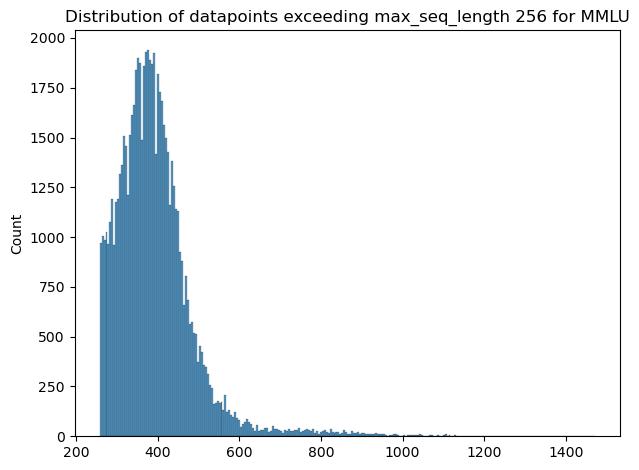

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = sns.histplot([el[1] for el in mmlu_exceeding])
ax.set_title(f"Distribution of datapoints exceeding max_seq_length {max_len} for MMLU");
plt.tight_layout()